In [ ]:
from tensorflow.keras import datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import losses

Load Data

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


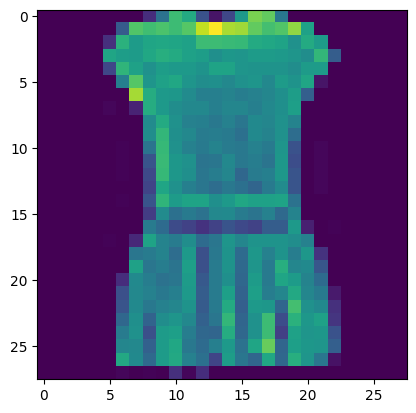

In [ ]:
plt.imshow(x_train[3])

Preprocess Data

In [ ]:
def preprocess_data(images):
  images = images.astype('float32') / 255.0
  images = np.pad(images, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
  images = np.expand_dims(images, -1)
  return images

In [ ]:
x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)

In [ ]:
x_train[0].shape

(32, 32, 1)

VAE Model

In [ ]:
# Sampling Layer
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = layers.Input(shape=(32, 32, 1), name='encoder_input')
x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
shape_before_flatten = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(2, name='z_mean')(x)
z_log_var = layers.Dense(2, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(2,), name='decoder_input')
x = layers.Dense(np.prod(shape_before_flatten))(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
decoder_output = layers.Conv2DTranspose(1, (3, 3), strides=1,activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = tf.keras.Model(decoder_input, decoder_output, name='decoder')

Training

In [ ]:
class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name='total_loss')
    self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
    self.kl_loss_tracker = metrics.Mean(name='kl_loss')

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker
    ]

  def call(self, inputs):
    z_mean, z_log_var, z = encoder(inputs)
    reconstruction = decoder(z)
    return z_mean, z_log_var, reconstruction

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, reconstruction = self(data)
      reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction, axis=(1,2,3)))
      kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis = 1))
      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {m.name: m.result() for m in self.metrics}

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

In [ ]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │         100,868 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 32, 32, 1)           │         246,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 347,141 (1.32 MB)

 Trainable params: 347,141 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae.fit(x_train, epochs=5, batch_size=100)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 189s 310ms/step - kl_loss: 3.4470 - reconstruction_loss: 184.5290 - total_loss: 187.9760
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 185s 308ms/step - kl_loss: 4.8491 - reconstruction_loss: 130.7290 - total_loss: 135.5781
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 196s 299ms/step - kl_loss: 4.9922 - reconstruction_loss: 128.5410 - total_loss: 133.5332
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 201s 297ms/step - kl_loss: 5.0737 - reconstruction_loss: 127.6773 - total_loss: 132.7509
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 202s 297ms/step - kl_loss: 5.1542 - reconstruction_loss: 126.8232 - total_loss: 131.9774


In [ ]:
vae.save_weights('vae.weights.h5')

Generate image

In [ ]:
embeddings = encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [ ]:
mins, max = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, max, size=(10000,2))
reconstructions = decoder.predict(sample)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


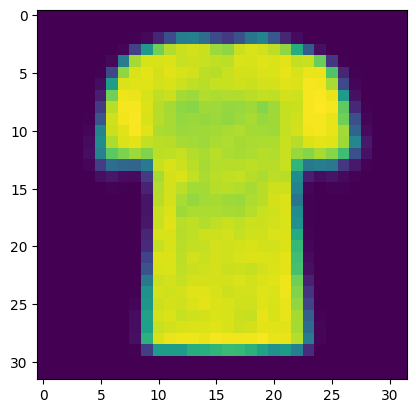

In [ ]:
plt.imshow(reconstructions[1])